- https://github.com/kairess/image_mosaic/blob/master/kmnist_bw.ipynb

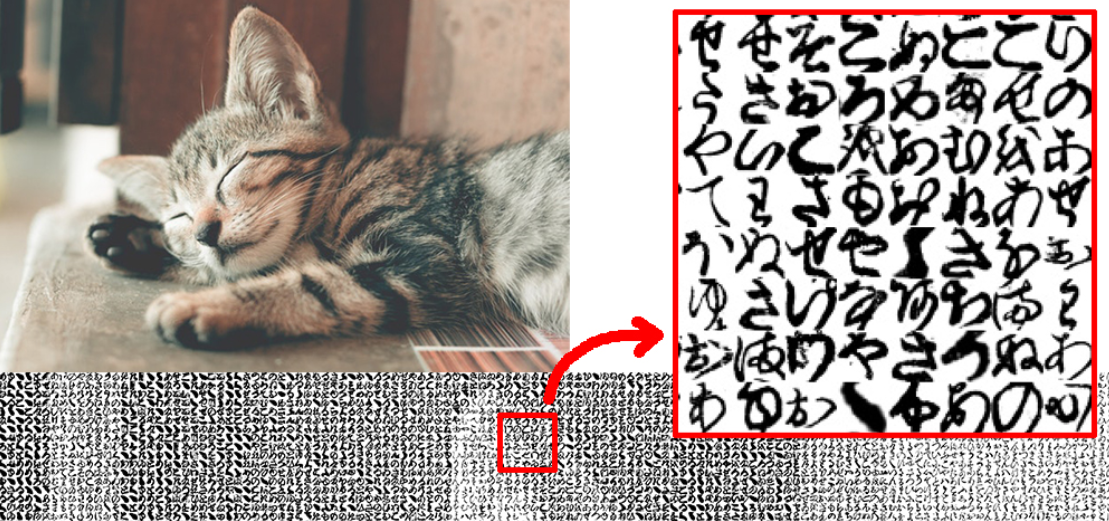

In [11]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [12]:
default_path = '/content/data/MyDrive/ai_lecture/2. Deep Learning/2. Vision Pytorch/Image_Preprocessing/data/'

In [13]:
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Load and Resize Image

In [51]:
img_path = default_path+'cat.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)

(426, 640)


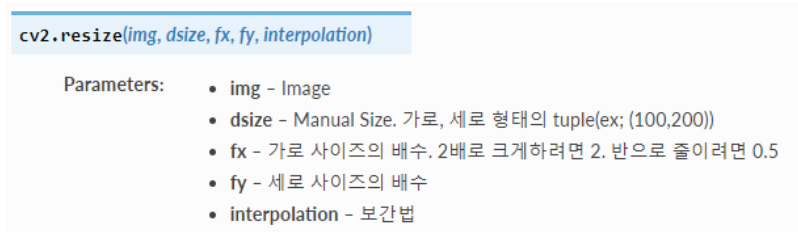

(85, 128)


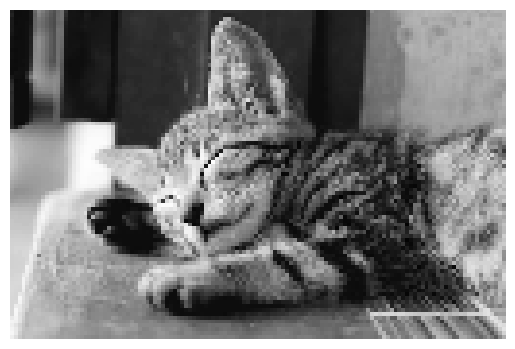

In [52]:
img = cv2.resize(img, dsize=None, fx=0.2, fy=0.2)

print(img.shape)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [53]:
import numpy as np

# 픽셀 -> 0(검정) ~ 255(흰색)
np.array(img)[:2]

array([[ 68,  56,  56,  57,  57,  63, 128, 156, 145, 132, 120, 111, 129,
        138,  85,  61,  62,  60,  58,  64,  63,  60,  61,  62,  64,  64,
         59,  57,  69,  80,  81,  82,  84,  85,  86,  85,  84,  86,  87,
         86,  86,  86,  86,  86,  84,  84,  86,  86,  89,  96, 105,  93,
         79,  81,  82,  85,  85,  84,  85,  84,  83,  82,  82,  81,  82,
         84,  82,  80,  80,  82,  83,  82,  83,  84,  83,  83,  82,  82,
         71,  57,  57,  62,  68,  70,  71,  73,  73,  74,  74,  74,  74,
         74, 107, 158, 148, 151, 151, 152, 162, 167, 178, 181, 183, 185,
        190, 189, 189, 193, 192, 193, 192, 194, 191, 191, 185, 182, 185,
        185, 190, 187, 182, 188, 190, 182, 188, 192, 190, 192],
       [ 73,  56,  56,  57,  57,  64, 124, 150, 139, 129, 117, 109, 131,
        137,  80,  62,  62,  61,  60,  67,  66,  61,  61,  63,  64,  65,
         58,  56,  71,  81,  81,  85,  86,  86,  86,  86,  85,  86,  84,
         84,  86,  86,  85,  85,  85,  86,  85,  87,  93, 10

# Preview Patch Images

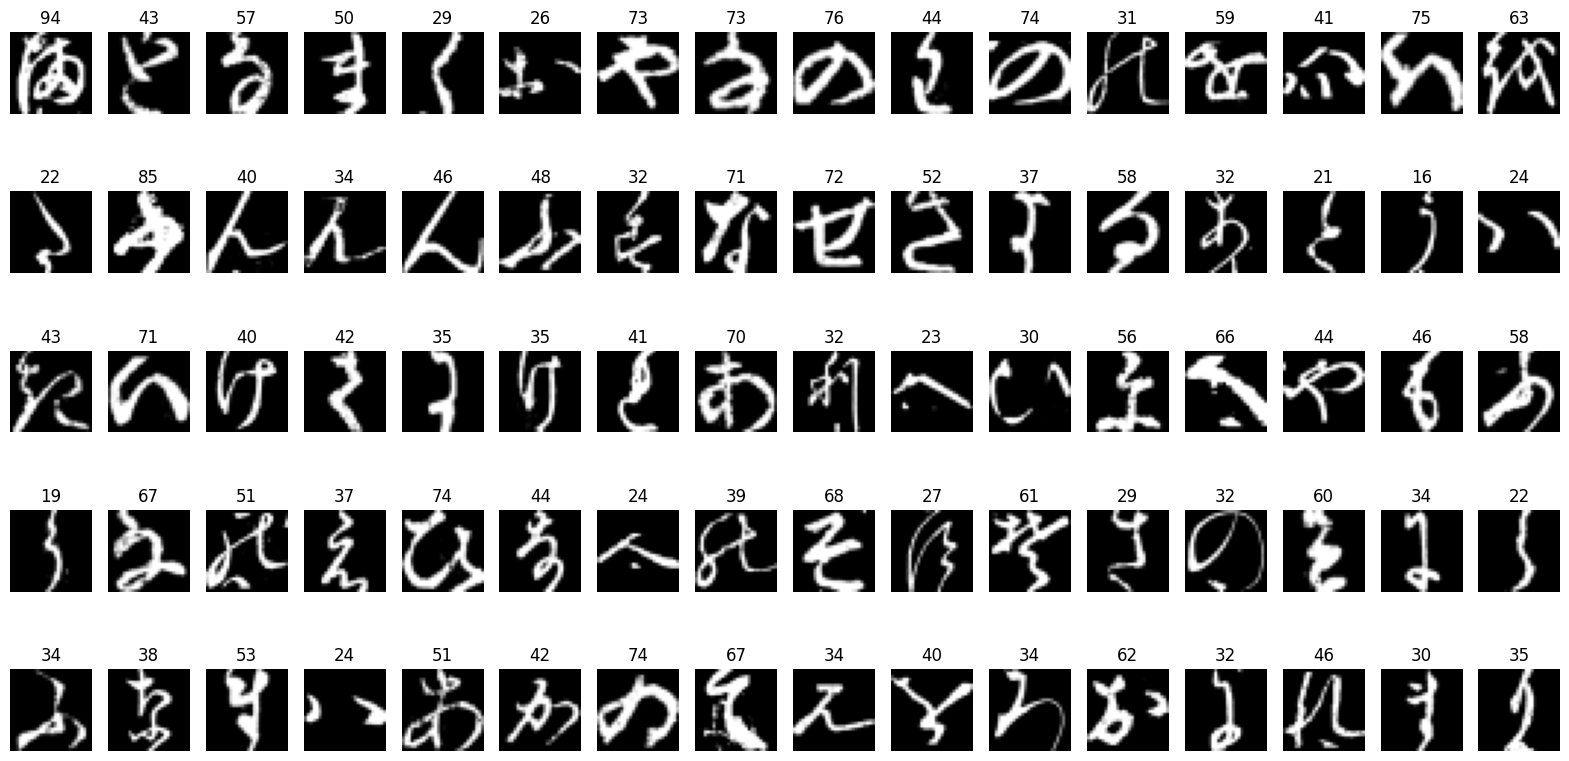

In [17]:
sample_imgs = np.load(default_path+'k49-train-imgs.npz')['arr_0']

plt.figure(figsize=(20, 10))
for i in range(80):
    # img_patch = 255 - sample_imgs[i]
    img_patch = sample_imgs[i]

    plt.subplot(5, 16, i+1)
    plt.title(int(np.mean(img_patch)))
    plt.axis('off')
    plt.imshow(img_patch, cmap='gray')

각 글자 이미지 크기

In [18]:
sample_imgs[i].shape

(28, 28)

# Distribution of Patch Images

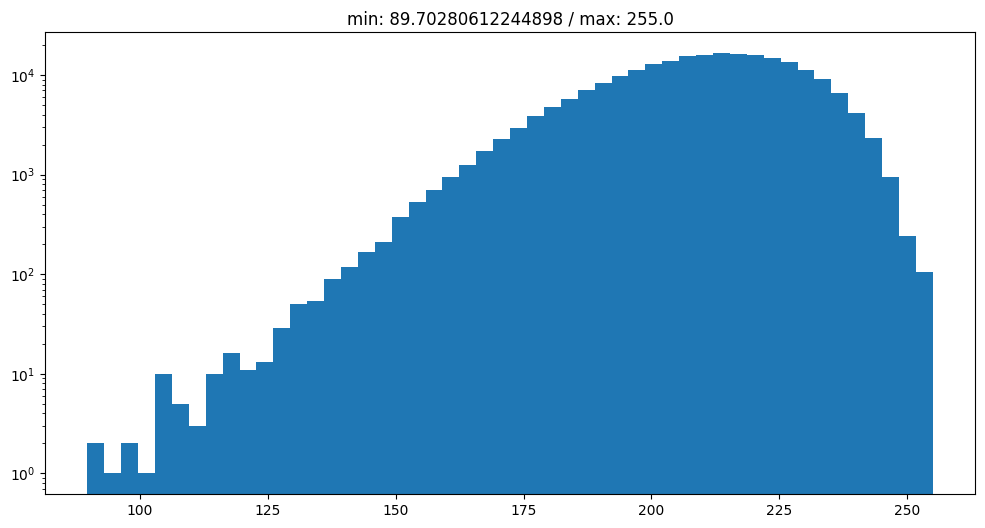

In [19]:
# 255 - sample_imgs
# -> 원본 이미지의 글자색이 흰색임으로 해당 글자색으로 검정색으로 변경
means = np.mean(255 - sample_imgs, axis=(1, 2))

plt.figure(figsize=(12, 6))
plt.hist(means, bins=50, log=True)
plt.title(f"min: {means.min()} / max: {means.max()}")
plt.show()

In [20]:
means[:5]

array([160.89668367, 211.74872449, 197.11734694, 204.53061224,
       225.55102041])

# Adjust MinMax of Input Image

## cv2.normalize()

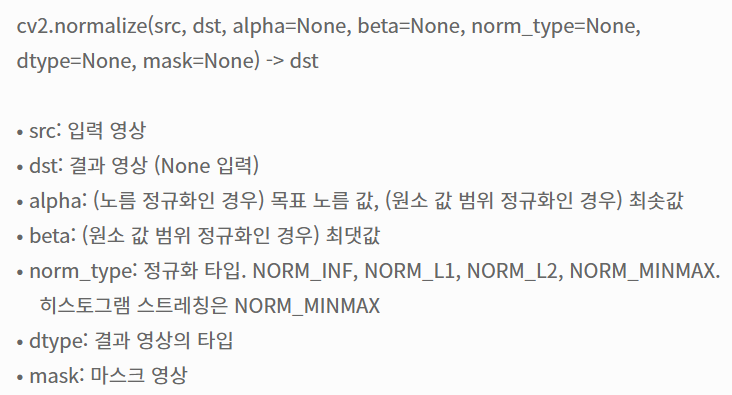

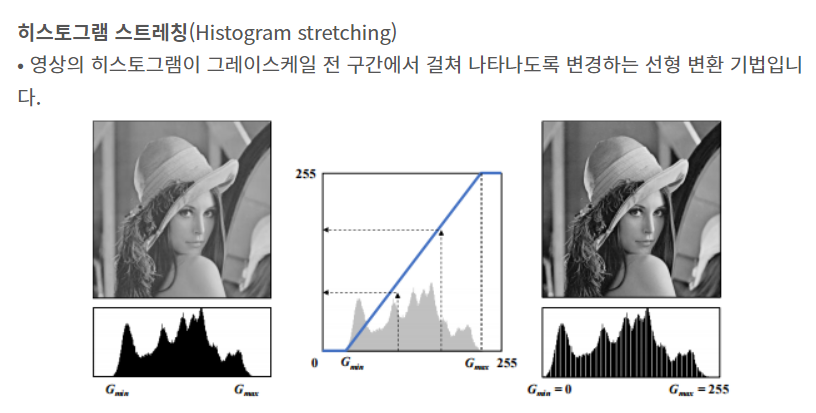

## 일본 글자의 최소/최대값으로 이미지를 변환

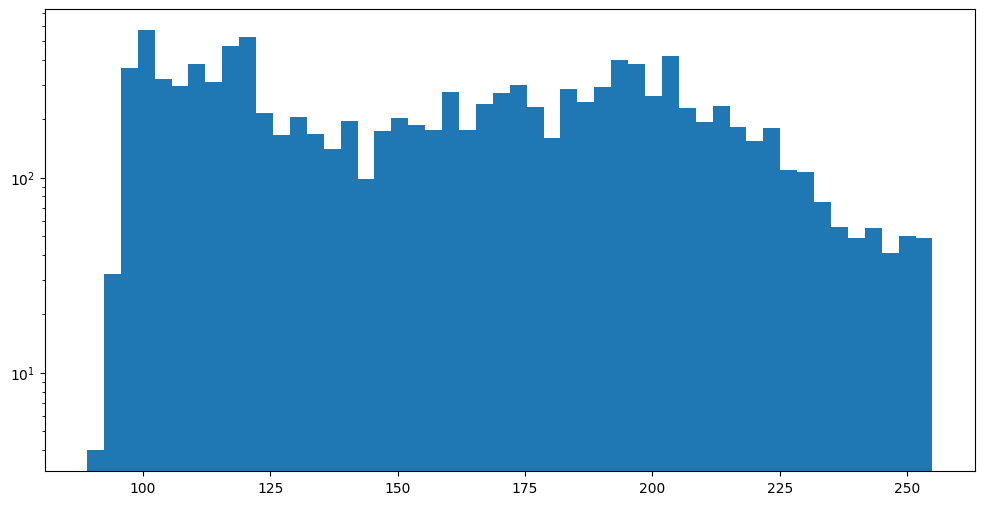

In [36]:
# normal_img = cv2.normalize(img, dst=None, alpha=120, beta=245, norm_type=cv2.NORM_MINMAX)
normal_img = cv2.normalize(img, dst=None, alpha=int(means.min()), beta=int(means.max()), norm_type=cv2.NORM_MINMAX)

plt.figure(figsize=(12, 6))
plt.hist(normal_img.flatten(), bins=50, log=True)
plt.show()

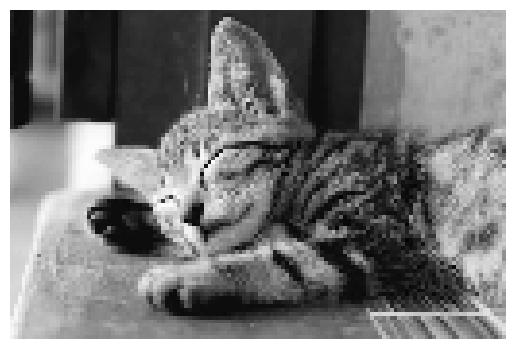

In [37]:
plt.imshow(normal_img, cmap='gray')
plt.axis('off')
plt.show()

In [38]:
img.min(), img.max()

(45, 253)

In [39]:
normal_img.min(), normal_img.max()

(89, 255)

In [40]:
normal_img.shape

(85, 128)

In [41]:
len(normal_img.flatten()) # 85 * 128

10880

In [42]:
normal_img.flatten()[:5]

array([107,  98,  98,  99,  99], dtype=uint8)

In [43]:
img[0][:5]

array([68, 56, 56, 57, 57], dtype=uint8)

# Organize Patch Images

In [44]:
bins = defaultdict(list)

for img_patch, mean in zip(sample_imgs, means):
    bins[int(mean)].append(img_patch)

print(len(bins))

156


In [45]:
len(bins[150]) # 평균 150인 글자 이미지가 107개 임!!

107

# Fill Images

In [46]:
img.shape

(85, 128)

In [47]:
normal_img.shape

(85, 128)

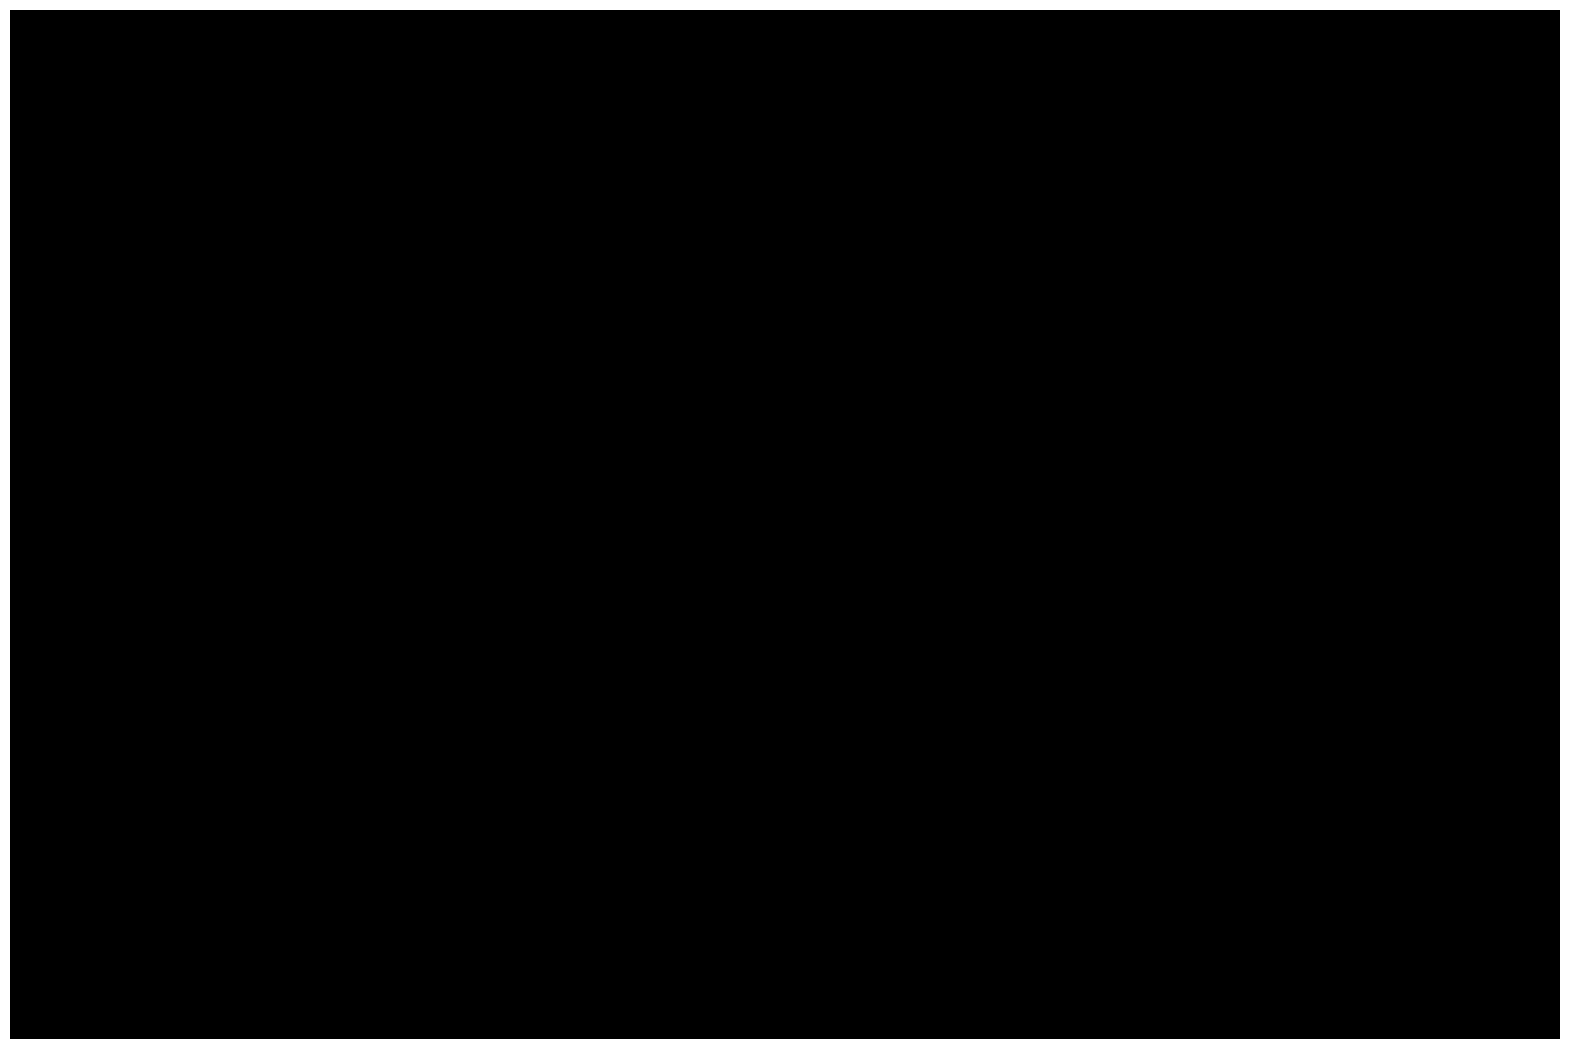

In [48]:
h, w = normal_img.shape

img_out = np.zeros((h*28, w*28), dtype=np.uint8) # 글자 이미지 크기가 (28,28) 따라서 높이와 너비에 28을 곱함.

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_out, cmap='gray')

In [49]:
h, w = normal_img.shape

img_out = np.zeros((h*28, w*28), dtype=np.uint8)

for y in range(h):
    for x in range(w):
        level = normal_img[y, x] # 특정 픽셀의 노말라이즈 값

        b = bins[level] # 해당 노말라이즈 값과 비슷한 문자 이미지 선택

        while len(b) == 0: # 해당 이미지가 없다면, 옆에 있는 이미지 선택
            level += 1
            b = bins[level]

        img_patch = 255 - b[np.random.randint(len(b))]  # 해당 글자 이미지들에서 렌덤으로 선택

        img_out[y*28:(y+1)*28, x*28:(x+1)*28] = img_patch # 특정 픽셀의 위치에 해당 글자 적용

plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(img_out, cmap='gray')

Output hidden; open in https://colab.research.google.com to view.